In [5]:
import numpy as np
import torch
import torch.optim as optim
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [19]:
def mock_classifier(x):
    """ Simulate a neural network's output. """
    return torch.rand(1, 10)  # Random scores for 10 classes

def adversarial_loss(output, target):
    """ Loss function that maximizes the error (for untargeted attack). """
    target_score = output[0, target]
    return -target_score  # Negative target score to maximize it

def generate_mask(shape, center, params, image_size):
    """ Generate different shapes of masks based on input parameters. """
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)

    if shape == 'circle':
        radius = params['radius']
        bounding_box = [center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius]
        draw.ellipse(bounding_box, fill=255)

    elif shape == 'ellipse':
        radius_x, radius_y = params['radius_x'], params['radius_y']
        bounding_box = [center[0] - radius_x, center[1] - radius_y, center[0] + radius_x, center[1] + radius_y]
        draw.ellipse(bounding_box, fill=255)

    elif shape == 'polygon':
        points = [(center[0] + x, center[1] + y) for x, y in params['vertices']]
        draw.polygon(points, fill=255)

    elif shape == 'star':
        outer_radius, inner_radius, num_points = params['outer_radius'], params['inner_radius'], params['num_points']
        points = []
        for i in range(2 * num_points):
            angle = i * np.pi / num_points
            radius = outer_radius if i % 2 == 0 else inner_radius
            points.append((center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle)))
        draw.polygon(points, fill=255)

    return np.array(image)


In [20]:
def generate_adversarial_patch(shape, params, target_class, iterations=100):
    center = (250, 250)
    image_size = (500, 500)

    texture = torch.rand(1, 3, *image_size, requires_grad=True)
    optimizer = optim.Adam([texture], lr=0.01)

    for i in range(iterations):
        optimizer.zero_grad()

        # Creating the mask and ensuring it is suitable for gradient tracking
        mask_np = generate_mask(shape, center, params, image_size)
        mask_tensor = torch.tensor(mask_np, dtype=torch.float32, device=texture.device) / 255.0
        mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)  # Adjusting dimensions for broadcasting

        # Ensuring patched image retains gradient tracking
        patched_image = texture * mask_tensor + texture * (1 - mask_tensor)
        output = mock_classifier(patched_image)
        loss = adversarial_loss(output, target_class)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    # Convert to numpy for visualization
    patch_array = texture.detach().cpu().permute(1, 2, 0).numpy()
    return patch_array

In [21]:
# Example usage
target_class = 7
shape_params = {'radius': 100}  # Parameters for a circle
patch = generate_adversarial_patch('circle', shape_params, target_class)
plt.imshow(patch)
plt.title("Generated Adversarial Patch")
plt.show()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Iteration 0, Loss: -0.5669569969177246
Iteration 10, Loss: -0.8415377140045166
Iteration 20, Loss: -0.5938682556152344
Iteration 30, Loss: -0.7308489084243774
Iteration 40, Loss: -0.20425069332122803
Iteration 50, Loss: -0.391143798828125
Iteration 60, Loss: -0.14403706789016724
Iteration 70, Loss: -0.9404195547103882
Iteration 80, Loss: -0.21923118829727173
Iteration 90, Loss: -0.014850318431854248


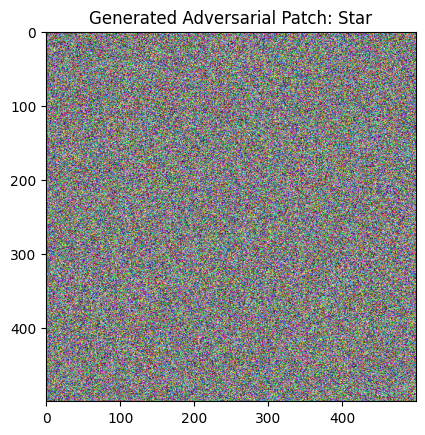

In [31]:
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def create_star_vertices(center, outer_radius, inner_radius, num_points):
    """Create vertices for a star shape based on center, outer and inner radius, and number of points."""
    angles = np.linspace(0, 2 * np.pi, 2 * num_points, endpoint=False)
    vertices = []
    for i, angle in enumerate(angles):
        if i % 2 == 0:
            # Outer radius point
            x = center[0] + outer_radius * np.cos(angle)
            y = center[1] + outer_radius * np.sin(angle)
        else:
            # Inner radius point
            x = center[0] + inner_radius * np.cos(angle)
            y = center[1] + inner_radius * np.sin(angle)
        vertices.append((x, y))
    return vertices

def generate_mask(center, image_size, vertices):
    """Generate a mask with a star shape."""
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)
    draw.polygon(vertices, fill=255)
    return np.array(image)

def mock_classifier(x):
    """Mock a classifier response."""
    return torch.rand(1, 10, requires_grad=True)

def adversarial_loss(output, target):
    """Mock adversarial loss for maximizing the error."""
    return -output[0, target]

def generate_adversarial_patch(center, image_size, outer_radius, inner_radius, num_points, target_class, iterations=100):
    texture = torch.rand(1, 3, *image_size, requires_grad=True)
    optimizer = optim.Adam([texture], lr=0.01)

    vertices = create_star_vertices(center, outer_radius, inner_radius, num_points)

    for i in range(iterations):
        optimizer.zero_grad()
        mask_np = generate_mask(center, image_size, vertices)
        mask_tensor = torch.tensor(mask_np, dtype=torch.float32, device=texture.device) / 255
        mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)

        patched_image = texture * mask_tensor + (1 - mask_tensor) * texture
        output = mock_classifier(patched_image)
        loss = adversarial_loss(output, target_class)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    patch_array = texture.detach().squeeze().permute(1, 2, 0).cpu().numpy()
    return patch_array

# Parameters for the star shape
center = (250, 250)
image_size = (500, 500)
outer_radius = 100
inner_radius = 50
num_points = 5
target_class = 7

# Generate the patch
patch = generate_adversarial_patch(center, image_size, outer_radius, inner_radius, num_points, target_class)
plt.imshow(patch)
plt.title("Generated Adversarial Patch: Star")
plt.show()
